In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [ ]:
dataset_dir = '/content/drive/MyDrive/105_classes_pins_dataset/6_classes_pins_dataset'


In [ ]:

# Get class names
class_names = os.listdir(dataset_dir)
class_names = [c for c in class_names if os.path.isdir(os.path.join(dataset_dir, c))]
num_classes = len(class_names)

# Print number of classes
print(f"Number of classes: {num_classes}")

Number of classes: 6


In [37]:
# Define image dimensions
img_height = 224
img_width = 224

In [38]:
# Create ImageDataGenerator for preprocessing
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
# Load images and split into train and validation
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='training',  # Use 80% for training
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='validation',  # Use 20% for validation
    shuffle=True
)

# Check the class labels
print(f"Class labels: {train_generator.class_indices}")

Found 647 images belonging to 6 classes.
Found 159 images belonging to 6 classes.
Class labels: {'pins_Bill Gates': 0, 'pins_Christian Bale': 1, 'pins_Cristiano Ronaldo': 2, 'pins_Lionel Messi': 3, 'pins_alycia dabnem carey': 4, 'pins_elon musk': 5}


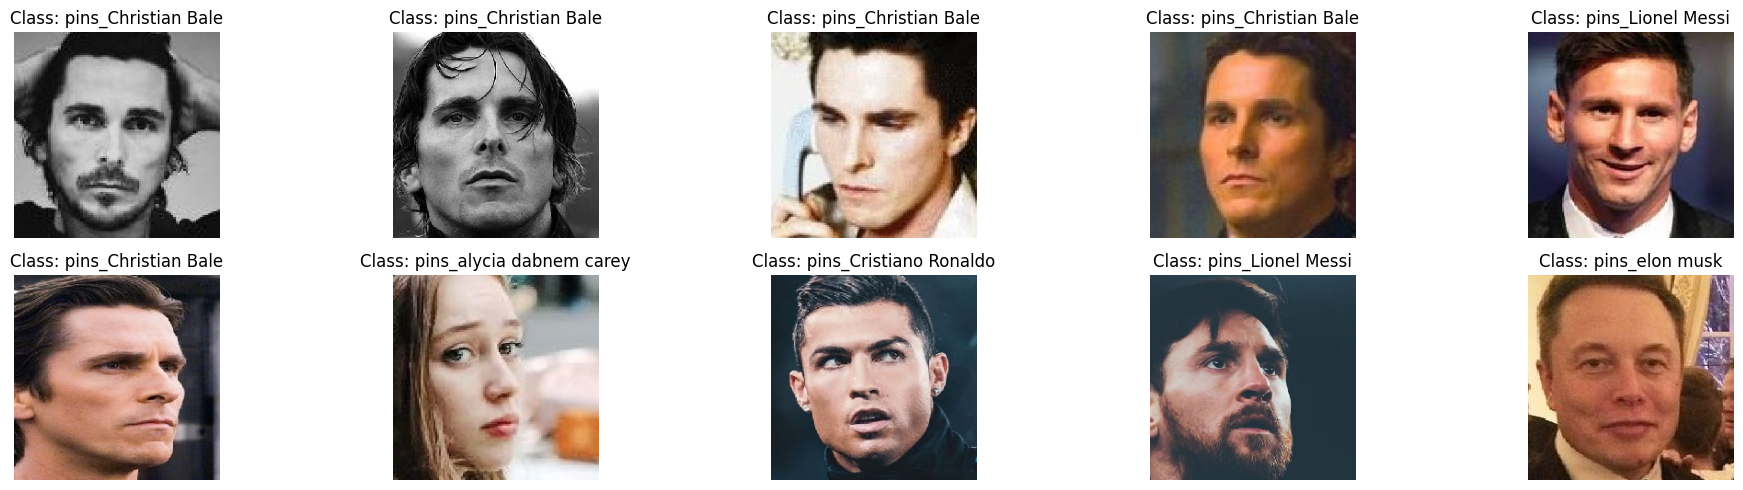

In [40]:
class_labels = list(train_generator.class_indices.keys())

# Reset the generator to start from the first batch
train_generator.reset()

# Fetch one batch of images and labels
images, labels = next(train_generator)

# Convert one-hot encoded labels to class indices
label_indices = np.argmax(labels, axis=1)

# Plot the first 10 images
plt.figure(figsize=(20, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)  # Create a 2x5 grid of subplots
    plt.imshow(images[i])  # Display the image
    plt.title(f"Class: {class_labels[label_indices[i]]}")  # Show the class label
    plt.axis('off')  # Hide axis

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input


In [ ]:
# Load the pretrained Xception model without the top layer
base_model = Xception(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_height, img_width, 3)))

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Freeze the base model to retain the pretrained weights
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)  # 6 output classes for 6 classes dataset

In [ ]:

# Create the full model
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Display the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 22,965,806 (87.61 MB)

 Trainable params: 2,104,326 (8.03 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5,  # Adjust epochs based on your dataset
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)

Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 632s 32s/step - accuracy: 0.5423 - loss: 1.2267 - val_accuracy: 0.7188 - val_loss: 0.7028
Epoch 2/5
 1/20 ━━━━━━━━━━━━━━━━━━━━ 9:47 31s/step - accuracy: 0.5625 - loss: 1.1069

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 433ms/step - accuracy: 0.5625 - loss: 1.1069 - val_accuracy: 0.7742 - val_loss: 0.6198
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 624s 31s/step - accuracy: 0.6653 - loss: 0.9615 - val_accuracy: 0.7500 - val_loss: 0.6741
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 409ms/step - accuracy: 0.6250 - loss: 1.3073 - val_accuracy: 0.6129 - val_loss: 0.8273
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 630s 31s/step - accuracy: 0.7067 - loss: 0.7853 - val_accuracy: 0.6953 - val_loss: 0.7577


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

# Predict on validation data
y_pred_probs = model.predict(val_generator, batch_size=32)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true = val_generator.classes

# Classification report (precision, recall, F1-score)
print(classification_report(y_true, y_pred, target_names=class_names))

5/5 ━━━━━━━━━━━━━━━━━━━━ 48s 8s/step
                          precision    recall  f1-score   support

pins_alycia dabnem carey       0.16      0.12      0.14        24
         pins_Bill Gates       0.08      0.07      0.07        30
     pins_Christian Bale       0.10      0.11      0.10        19
  pins_Cristiano Ronaldo       0.04      0.06      0.05        17
          pins_elon musk       0.37      0.40      0.39        42
       pins_Lionel Messi       0.08      0.07      0.08        27

                accuracy                           0.17       159
               macro avg       0.14      0.14      0.14       159
            weighted avg       0.17      0.17      0.17       159



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict on validation data
y_pred_probs = model.predict(val_generator, batch_size=32)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true = val_generator.classes

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Precision (macro-averaged for all classes)
precision = precision_score(y_true, y_pred, average='macro')
print(f"Precision: {precision:.2f}")

# Recall (macro-averaged for all classes)
recall = recall_score(y_true, y_pred, average='macro')
print(f"Recall: {recall:.2f}")

# F1-score (macro-averaged for all classes)
f1 = f1_score(y_true, y_pred, average='macro')
print(f"F1-Score: {f1:.2f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 37s 8s/step
Accuracy: 0.16
Precision: 0.14
Recall: 0.14
F1-Score: 0.14


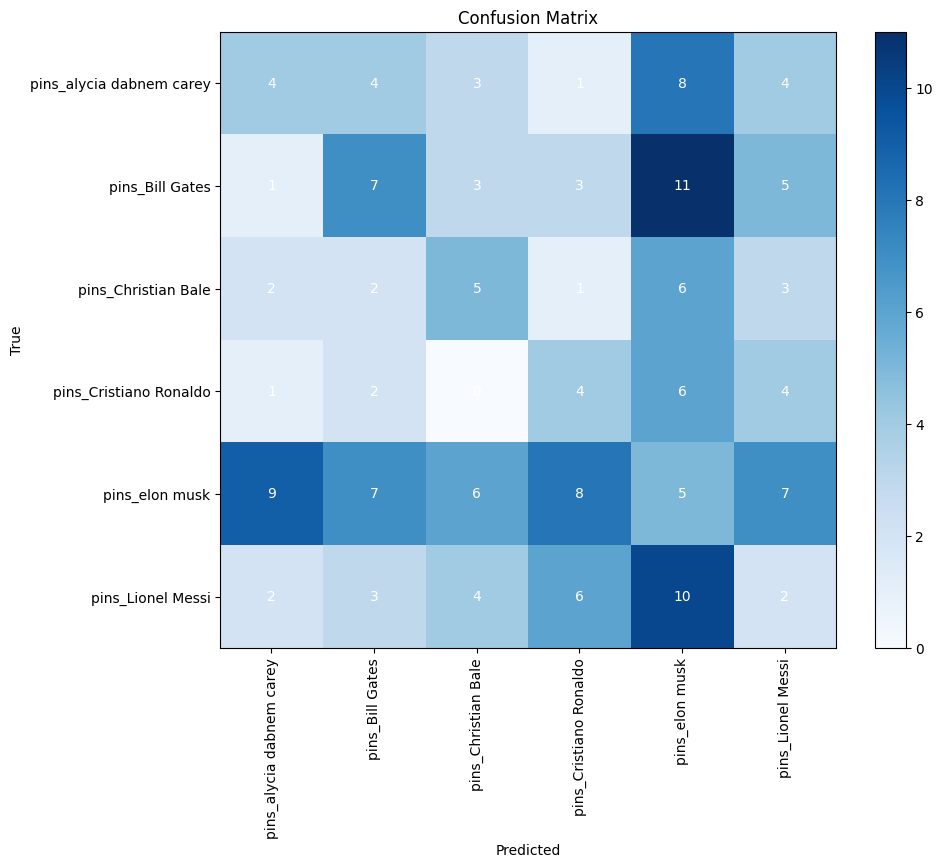

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a figure for the confusion matrix
plt.figure(figsize=(10, 8))

# Plot the confusion matrix with a color map
plt.imshow(cm, cmap='Blues')

# Title and labels
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(np.arange(num_classes), class_names, rotation=90)
plt.yticks(np.arange(num_classes), class_names)

# Annotate each cell with the numeric value
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, f'{cm[i, j]}', ha='center', va='center', color='white')

# Show the plot
plt.show()


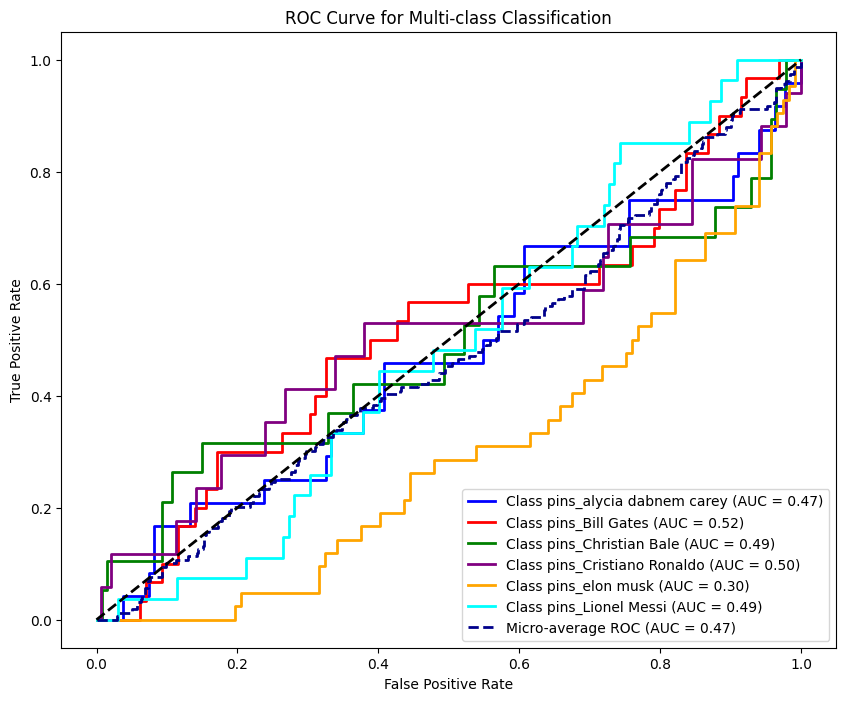

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

# Ensure y_true is label-binarized for multi-class ROC/AUC
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))  # Convert to one-hot
n_classes = y_true_bin.shape[1]  # Number of classes

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area (useful for overall metrics)
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'purple', 'orange', 'cyan'])

for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.2f})"
    )

# Plot the micro-average ROC curve
plt.plot(
    fpr["micro"],
    tpr["micro"],
    color='darkblue',
    linestyle='--',
    lw=2,
    label=f"Micro-average ROC (AUC = {roc_auc['micro']:.2f})"
)

# Add diagonal line for random guess
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Configure plot
plt.title("ROC Curve for Multi-class Classification")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


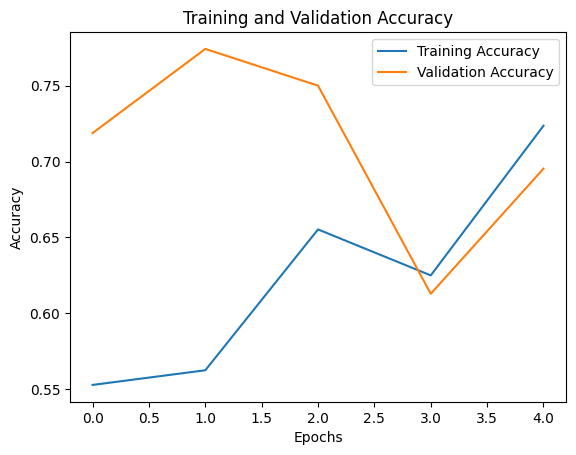

In [41]:
# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

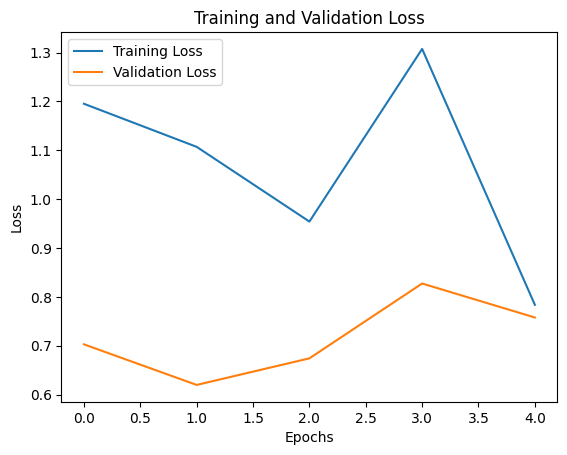

In [42]:
# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()